#Introduction
Throughout this notebook I'll be trying to predict HIV case counts around the world based on various indicators such as condom use, a person's comprehensive knowledge, age, and gender from Kaggle's public dataset (which can be found in the drive). I'll walk you through the entire process by downloading and acquiring preliminary datasets, extracting features, conducting EDA, and doing modeling.

Let's begin!

# Part 0 : Before Running

Remember to upload your kaggle.json file (kaggle account required) to colab after you run the following channel. Or, you can directly download file from https://www.kaggle.com/theworldbank/health-nutrition-and-population-statistics and upload to colab.

🆘 If you don't want to run it, make sure to load it in Colab to have a complete view of our data visualization.

## Installing the Kaggle API in Colab

The dataset we use from kaggle. If you wish to run this notebook, you can do following steps:


First, grab your token from Kaggle.
1. Navigate to https://www.kaggle.com.
2. Then go to the [Account tab of your user profile](https://www.kaggle.com/me/account).
3. select Create API Token. This will trigger the download of kaggle.json, a file containing your API credentials.

Then run the cell below to upload kaggle.json to your Colab runtime.

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

## Downloading Dataset

In [ ]:
# ! pip install kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download theworldbank/health-nutrition-and-population-statistics
! unzip health-nutrition-and-population-statistics
! pip install pycountry
! pip install pycountry-convert

 36% 5.00M/14.0M [00:00<00:00, 28.6MB/s]
100% 14.0M/14.0M [00:00<00:00, 54.2MB/s]
Archive:  health-nutrition-and-population-statistics.zip
  inflating: data.csv                
     |████████████████████████████████| 10.1 MB 6.0 MB/s 
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746883 sha256=bb56bb0484c3c263acb3e74cfd46cad9f21b822e675efd156f2b974b00a5a974
  Stored in directory: /root/.cache/pip/wheels/57/e8/3f/120ccc1ff7541c108bc5d656e2a14c39da0d824653b62284c6
Successfully built pycountry
     |████████████████████████████████| 280 kB 7.9 MB/s 
     |████████████████████████████████| 213 kB 11.6 MB/s 
     |████████████████████████████████| 280 kB 1.9 MB/s 
     |████████████████████████████████| 280 kB 36.8 MB/s 
     |████████████████████████████████| 280 kB 46.0 MB/s 
     |████████████████████████████████| 279 kB 24.8 MB/s 
     |████████████████████████████████| 279 kB 44.2 MB/s 
     |████████████████████████████████| 272 kB 36.7 MB/s 
   

# Part 1 : Data Extraction & Cleaning

In [ ]:
import pandas as pd
import pycountry_convert as pc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## Data Loading

We are loading the Health Nutrition and Population Statistics data.csv file that we downloaded from Kaggle.

Load `data.csv` as `data_df`.

In [ ]:
data_df = pd.read_csv('data.csv')
data_df.head(5)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,Unnamed: 60
0,Arab World,ARB,% of females ages 15-49 having comprehensive c...,SH.HIV.KNOW.FE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,% of males ages 15-49 having comprehensive cor...,SH.HIV.KNOW.MA.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,133.555013,134.159119,134.857912,134.504576,134.105211,133.569626,132.675635,131.665502,129.19098,126.736756,124.382809,122.133431,120.020186,118.087531,116.132988,114.100918,111.980005,109.783822,106.033489,102.341721,98.739002,95.241251,91.791192,88.001177,84.207256,80.359323,76.441596,72.51458,71.170664,69.888768,69.004413,67.755992,66.928451,64.948968,62.922778,60.70707,58.596631,56.440128,55.53154,54.658781,53.83141,52.901528,51.990793,51.522856,51.10325,50.73259,50.329135,49.999851,49.887046,49.781207,49.672975,49.536047,49.383745,48.796558,48.196418,NaN,NaN
3,Arab World,ARB,Adults (ages 15+) and children (0-14 years) li...,SH.HIV.TOTL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arab World,ARB,Adults (ages 15+) and children (ages 0-14) new...,SH.HIV.INCD.TL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Cleaning and Preprocessing

In this section we will

*   Clean the data by removing nulls, duplicating, unwanted column like `Unnamed: 60` and regions
*   Create a helper function to help indentify regions in the country name column in order to delete them.
*   Store the processed data into cleaned_df.


In [ ]:
# drop the last column
data_df = data_df.iloc[:, :-1]

data_df.drop_duplicates(inplace=True)

* Here we created a helper function to help indentify region's name from Country Name column.

In [ ]:
#check regions in dataset in order to remove them
columns=[i for i in range(4,60)]
data_df=data_df[data_df.iloc[:,columns].any(not None)]
#store world_df here for future use
world_df=data_df[data_df["Country Code"]=="WLD"]
regions=set()
#referenced from https://towardsdatascience.com/using-python-to-create-a-world-map-from-a-list-of-country-names-cd7480d03b10
def check_country(country):
    try:
        country_code = pc.country_name_to_country_alpha2(country)
        try:
          continent_code = pc.country_alpha2_to_continent_code(country_code)
        except:
          regions.add(country)
    except:
        regions.add(country)
check=data_df["Country Name"].apply(lambda x:check_country(x))

Those are some regions we did not consider due to the overlap with countries.

In [ ]:
regions

{'Arab World',
 'Bahamas, The',
 'Caribbean small states',
 'Central Europe and the Baltics',
 'Channel Islands',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 "Cote d'Ivoire",
 'Curacao',
 'Early-demographic dividend',
 'East Asia & Pacific',
 'East Asia & Pacific (IDA & IBRD countries)',
 'East Asia & Pacific (excluding high income)',
 'Egypt, Arab Rep.',
 'Euro area',
 'Europe & Central Asia',
 'Europe & Central Asia (IDA & IBRD countries)',
 'Europe & Central Asia (excluding high income)',
 'European Union',
 'Fragile and conflict affected situations',
 'Gambia, The',
 'Heavily indebted poor countries (HIPC)',
 'High income',
 'Hong Kong SAR, China',
 'Iran, Islamic Rep.',
 'Korea, Dem. People’s Rep.',
 'Korea, Rep.',
 'Kosovo',
 'Lao PDR',
 'Late-demographic dividend',
 'Latin America & Caribbean',
 'Latin America & Caribbean (excluding high income)',
 'Latin America & the Caribbean (IDA & IBRD countries)',
 'Least developed countries: UN classification',
 'Low & middle income',
 'Low inc

In [ ]:
#remove regions
cleaned_df=data_df[~data_df["Country Name"].isin(regions)]
cleaned_df["Continent Code"]=cleaned_df["Country Name"].apply(lambda x:pc.country_alpha2_to_continent_code(pc.country_name_to_country_alpha2(x)))
cleaned_df["Continent Name"]=cleaned_df["Continent Code"].apply(lambda x:pc.convert_continent_code_to_continent_name(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
cleaned_df.head(5)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,Continent Code,Continent Name
14145,Afghanistan,AFG,% of females ages 15-49 having comprehensive c...,SH.HIV.KNOW.FE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5000,NaN,NaN,NaN,NaN,AS,Asia
14147,Afghanistan,AFG,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,145.321,145.321,145.321,145.321,145.321,145.321,145.321,145.321,145.321,145.321,145.321,145.321,145.321,146.215,147.109,148.003,148.897,149.791,150.8782,151.9654,153.0526,154.1398,155.227,156.3758,157.5246,158.6734,159.8222,160.971,161.56,162.149,162.738,163.327,163.916,164.1812,164.4464,164.7116,164.9768,165.242,161.4432,157.6444,153.8456,150.0468,146.248,140.4764,134.7048,128.9332,123.1616,117.39,111.4708,105.5516,99.6324,93.7132,87.794,82.2638,76.7336,NaN,AS,Asia
14148,Afghanistan,AFG,Adults (ages 15+) and children (0-14 years) li...,SH.HIV.TOTL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.000,500.000,1000.000,1000.0000,1000.0000,1100.0000,1300.0000,1400.000,1600.0000,1700.0000,1900.0000,2100.0000,2300.000,2600.0000,2800.0000,3100.0000,3300.0000,3500.00,3800.0000,4200.0000,4500.0000,4900.0000,5300.000,5900.0000,6400.0000,6900.0,AS,Asia
14149,Afghanistan,AFG,Adults (ages 15+) and children (ages 0-14) new...,SH.HIV.INCD.TL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000,200.000,200.000,200.0000,200.0000,500.0000,500.0000,500.000,500.0000,500.0000,500.0000,500.0000,500.000,500.0000,500.0000,500.0000,500.0000,1000.00,1000.0000,1000.0000,1000.0000,1000.0000,1000.000,1000.0000,1000.0000,1000.0,AS,Asia
14150,Afghanistan,AFG,Adults (ages 15+) living with HIV,SH.DYN.AIDS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.000,500.000,1000.000,1000.0000,1000.0000,1100.0000,1200.0000,1400.000,1500.0000,1600.0000,1800.0000,2000.0000,2200.000,2500.0000,2700.0000,3000.0000,3200.0000,3400.00,3700.0000,4000.0000,4300.0000,4700.0000,5200.000,5600.0000,6200.0000,6700.0,AS,Asia


* Save the cleaned dataframe to a new csv file.

In [ ]:
cleaned_df.to_csv("cleaned.csv")

# Part 2 : Data Visualization

## Identify key indicators related to HIV counts

* Here we create a dictionary that consist Indicator Codes and Indicator Names that contains the key word 'HIV'.

In [ ]:
indicator_dict={}
for a,b in zip(cleaned_df["Indicator Code"], cleaned_df["Indicator Name"]):
  indicator_dict[a]=b
all_indicators=list(cleaned_df["Indicator Code"].unique())
HIV_indicators=[x for x in all_indicators if 'HIV' in x]
HIV_dict={}
for key, val in indicator_dict.items():
  if key in HIV_indicators:
    HIV_dict[key]=val

In [ ]:
HIV_dict

{'SH.HIV.0014': 'Children (0-14) living with HIV',
 'SH.HIV.1524.FE.ZS': 'Prevalence of HIV, female (% ages 15-24)',
 'SH.HIV.1524.KW.FE.ZS': 'Comprehensive correct knowledge of HIV/AIDS, ages 15-24, female (2 prevent ways and reject 3 misconceptions)',
 'SH.HIV.1524.KW.MA.ZS': 'Comprehensive correct knowledge of HIV/AIDS, ages 15-24, male (2 prevent ways and reject 3 misconceptions)',
 'SH.HIV.1524.MA.ZS': 'Prevalence of HIV, male (% ages 15-24)',
 'SH.HIV.ARTC.ZS': 'Antiretroviral therapy coverage (% of people living with HIV)',
 'SH.HIV.INCD': 'Adults (ages 15+) newly infected with HIV',
 'SH.HIV.INCD.14': 'Children (ages 0-14) newly infected with HIV',
 'SH.HIV.INCD.TL': 'Adults (ages 15+) and children (ages 0-14) newly infected with HIV',
 'SH.HIV.INCD.ZS': 'Incidence of HIV (% of uninfected population ages 15-49)',
 'SH.HIV.KNOW.FE.ZS': '% of females ages 15-49 having comprehensive correct knowledge about HIV (2 prevent ways and reject 3 misconceptions)',
 'SH.HIV.KNOW.MA.ZS': '%

## Mean, Standard Deviation, Min, and Max for countries

* Compute some simple statistics like mean, standard deviation, min and max for the numerical features (each year) in the dataset and store them into lists in order `['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015']`.
* Since it lacks too much data before 1990, we clean the data again by dropping columns prior to year 1990.


In [ ]:
unused_years=[str(y) for y in range(1960,1990)]
used_years=[str(y) for y in range(1990,2016)]
cleaned_df.drop(columns=unused_years,inplace=True)
world_df.drop(columns=unused_years,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
cleaned_df

,Country Name,Country Code,Indicator Name,Indicator Code,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,Continent Code,Continent Name
14145,Afghanistan,AFG,% of females ages 15-49 having comprehensive c...,SH.HIV.KNOW.FE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.500000,NaN,NaN,NaN,NaN,AS,Asia
14147,Afghanistan,AFG,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,162.738000,163.327000,163.916000,164.181200,164.446400,164.711600,164.97680,165.242000,161.443200,157.644400,153.845600,150.046800,146.24800,140.476400,134.704800,128.933200,123.161600,117.390000,111.470800,105.551600,99.632400,93.713200,87.79400,82.263800,76.733600,NaN,AS,Asia
14148,Afghanistan,AFG,Adults (ages 15+) and children (0-14 years) li...,SH.HIV.TOTL,500.000000,500.000000,1000.000000,1000.000000,1000.000000,1100.000000,1300.00000,1400.000000,1600.000000,1700.000000,1900.000000,2100.000000,2300.00000,2600.000000,2800.000000,3100.000000,3300.000000,3500.000000,3800.000000,4200.000000,4500.000000,4900.000000,5300.00000,5900.000000,6400.000000,6900.000000,AS,Asia
14149,Afghanistan,AFG,Adults (ages 15+) and children (ages 0-14) new...,SH.HIV.INCD.TL,100.000000,200.000000,200.000000,200.000000,200.000000,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,AS,Asia
14150,Afghanistan,AFG,Adults (ages 15+) living with HIV,SH.DYN.AIDS,500.000000,500.000000,1000.000000,1000.000000,1000.000000,1100.000000,1200.00000,1400.000000,1500.000000,1600.000000,1800.000000,2000.000000,2200.00000,2500.000000,2700.000000,3000.000000,3200.000000,3400.000000,3700.000000,4000.000000,4300.000000,4700.000000,5200.00000,5600.000000,6200.000000,6700.000000,AS,Asia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89005,Zimbabwe,ZWE,Use of insecticide-treated bed nets (% of unde...,SH.MLR.NETS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.100000,NaN,NaN,17.300000,NaN,9.700000,NaN,NaN,26.800000,NaN,AF,Africa
89006,Zimbabwe,ZWE,Use of Intermittent Preventive Treatment of ma...,SH.MLR.SPF2.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.300000,NaN,NaN,13.900000,NaN,7.300000,NaN,NaN,12.900000,NaN,AF,Africa
89007,Zimbabwe,ZWE,Vitamin A supplementation coverage rate (% of ...,SN.ITK.VITA.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.00000,19.000000,20.000000,81.000000,67.000000,83.000000,0.000000,77.000000,49.000000,47.000000,61.00000,34.000000,32.000000,NaN,AF,Africa
89008,Zimbabwe,ZWE,Wanted fertility rate (births per woman),SP.DYN.WFRT,NaN,NaN,NaN,NaN,3.500000,NaN,NaN,NaN,NaN,3.400000,NaN,NaN,NaN,NaN,NaN,NaN,3.300000,NaN,NaN,NaN,NaN,3.500000,NaN,NaN,NaN,NaN,AF,Africa


In [ ]:
total_HIV_df=cleaned_df[(cleaned_df["Indicator Code"]=="SH.HIV.TOTL")]
stats=total_HIV_df[used_years].describe()
stats
# means = total_HIV_df[years].mean()[]
# stds = total_HIV_df[years].std().tolist()
# mins = total_HIV_df[years].min().tolist()
# maxes = total_HIV_df[years].max().tolist()

# print(maxes)
# print(mins)
# print(stds)
# print(means)

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
count,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01
mean,7.272222e+04,8.833636e+04,1.062040e+05,1.249525e+05,1.446364e+05,1.642030e+05,1.851505e+05,2.039162e+05,2.208939e+05,2.360222e+05,2.482313e+05,2.585051e+05,2.635657e+05,2.706636e+05,2.724606e+05,2.725323e+05,2.741717e+05,2.746202e+05,2.784040e+05,2.808576e+05,2.861434e+05,2.893525e+05,2.928040e+05,2.973747e+05,3.044212e+05,3.102889e+05
std,1.868599e+05,2.159691e+05,2.522798e+05,2.929436e+05,3.380946e+05,3.909992e+05,4.516894e+05,5.124345e+05,5.731511e+05,6.288052e+05,6.808404e+05,7.250071e+05,7.477593e+05,7.764626e+05,7.853301e+05,7.829808e+05,7.828769e+05,7.803782e+05,7.785542e+05,7.801012e+05,7.875102e+05,7.892797e+05,8.011552e+05,8.120797e+05,8.356392e+05,8.569770e+05
min,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02
25%,7.500000e+02,1.000000e+03,1.000000e+03,1.100000e+03,1.700000e+03,2.400000e+03,3.300000e+03,4.600000e+03,5.500000e+03,6.250000e+03,7.500000e+03,8.050000e+03,8.800000e+03,9.500000e+03,9.600000e+03,9.550000e+03,9.650000e+03,9.900000e+03,1.100000e+04,1.200000e+04,1.250000e+04,1.350000e+04,1.400000e+04,1.450000e+04,1.500000e+04,1.500000e+04
50%,4.900000e+03,6.500000e+03,8.200000e+03,9.400000e+03,1.100000e+04,1.300000e+04,1.500000e+04,2.200000e+04,2.300000e+04,2.800000e+04,3.100000e+04,3.100000e+04,3.700000e+04,4.000000e+04,4.100000e+04,4.500000e+04,4.700000e+04,4.500000e+04,4.300000e+04,4.300000e+04,4.600000e+04,4.700000e+04,4.700000e+04,4.700000e+04,4.700000e+04,4.700000e+04
75%,3.100000e+04,3.700000e+04,4.750000e+04,5.600000e+04,6.550000e+04,7.700000e+04,9.550000e+04,1.100000e+05,1.100000e+05,1.200000e+05,1.300000e+05,1.450000e+05,1.450000e+05,1.550000e+05,1.650000e+05,1.650000e+05,1.650000e+05,1.700000e+05,1.750000e+05,1.750000e+05,1.800000e+05,1.750000e+05,1.750000e+05,1.800000e+05,1.850000e+05,1.900000e+05
max,1.100000e+06,1.100000e+06,1.200000e+06,1.300000e+06,1.500000e+06,2.000000e+06,2.700000e+06,3.400000e+06,4.100000e+06,4.700000e+06,5.300000e+06,5.800000e+06,6.100000e+06,6.400000e+06,6.500000e+06,6.500000e+06,6.500000e+06,6.500000e+06,6.400000e+06,6.400000e+06,6.400000e+06,6.400000e+06,6.500000e+06,6.600000e+06,6.800000e+06,7.000000e+06


## Plot HIV counts for each country and continent

In this section, we are going to create visual images for the average distribution of Total HIV count.

1. Calculate the mean of Total HIV counts over the years for each country.
2. Create box plot that shows the average HIV count for each country over the years.
3. Create pie charts for average precentage distribution of HIV counts around the world and at different continents.
4. Create world maps for average data distribution of HIV counts around the world.

In [ ]:
total_HIV_df["mean"]=total_HIV_df.mean(axis=1) # This mean value is useful for our following plots

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


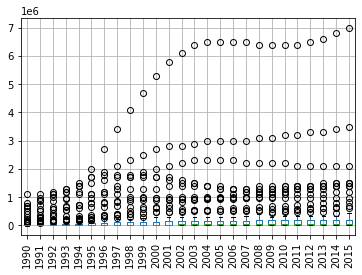

In [ ]:
total_HIV_df.boxplot(column=used_years,rot=90)

#### Data Percentage Distribution By Country
**Motivation:** In the dataset, there is geographic information. We are curious about the average precentage distribution of HIV counts around the world.

**Conclusion:** From the pie chart below, we see that the top three countries that have high percentage of HIV counts is South Africa, Nigeria, and India.

In [ ]:
import pycountry
import plotly.express as px

px.pie(total_HIV_df, values='mean', names='Country Name',
       title='Average Total HIV Percentage for Different Countries',
       color_discrete_sequence=px.colors.sequential.RdBu)

#### Data Percentage Distribution By Continents
**Motivation:** In the dataset, there is geographic information. We are curious about the average precentage distribution of HIV counts at each continent.

**Conclusion:** From the pie chart below, we see that the continent that has highest percentage of people living with HIV is Africa with a precentage of 78.7%.

In [ ]:
px.pie(total_HIV_df, values='mean', names='Continent Name',
       title='Average Total HIV Percentage for Different Continents',
       color_discrete_sequence=px.colors.sequential.RdBu)

#### Data Point Distribution By Country
**Motivation:** In the dataset, there is geographic information. We are curious about the average distribution of HIV counts around the world from 1990 to 2015.

In [ ]:
fig = px.scatter_geo(total_HIV_df, locations="Country Code",
                     color="Country Name", # which column to use to set the color of markers
                     hover_name="Country Name", # column added to hover information
                     size="mean", # size of markers
                     projection="orthographic",
                     title="Average Total HIV Counts for different Countries from 1990 to 2015")
fig

#### Data Point Distribution By Continents
**Motivation:** In the dataset, there is geographic information. We are curious about the average distribution of HIV counts at each continent from 1990 to 2015.

In [ ]:
fig = px.scatter_geo(total_HIV_df, locations="Country Code",
                     color="Continent Name", # which column to use to set the color of markers
                     hover_name="Country Name", # column added to hover information
                     size="mean", # size of markers
                     projection="orthographic",
                     title="Average Total HIV Counts for different Continents from 1990 to 2015")
fig

## Plot HIV counts for each country and continent among children

In this section, we are going to create visual images for the average distribution of Children (0-14) living with HIV.

1. Calculate the mean for Children (0-14) living with HIV over the years for each country.
2. Create box plot that shows the average count for each country over the years.
3. Create pie charts for average precentage distribution around the world and at different continents.
4. Create world maps for average data distribution around the world.

In [ ]:
children_HIV_df=cleaned_df[(cleaned_df["Indicator Code"]=="SH.HIV.0014")]
children_HIV_df["mean"]=children_HIV_df.mean(axis=1)
children_HIV_df.sort_values(by=["mean"],ascending=False).head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Country Name,Country Code,Indicator Name,Indicator Code,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,Continent Code,Continent Name,mean
74938,South Africa,ZAF,Children (0-14) living with HIV,SH.HIV.0014,5800.0,10000.0,17000.0,27000.0,40000.0,58000.0,81000.0,110000.0,140000.0,170000.0,200000.0,230000.0,260000.0,290000.0,320000.0,340000.0,350000.0,360000.0,370000.0,360000.0,340000.0,320000.0,300000.0,280000.0,260000.0,240000.0,AF,Africa,210723.076923
63898,Nigeria,NGA,Children (0-14) living with HIV,SH.HIV.0014,28000.0,35000.0,45000.0,56000.0,69000.0,83000.0,99000.0,120000.0,130000.0,150000.0,170000.0,180000.0,200000.0,210000.0,220000.0,240000.0,240000.0,250000.0,260000.0,260000.0,260000.0,270000.0,270000.0,270000.0,260000.0,260000.0,AF,Africa,178269.230769
48718,Kenya,KEN,Children (0-14) living with HIV,SH.HIV.0014,38000.0,51000.0,65000.0,81000.0,97000.0,110000.0,130000.0,140000.0,160000.0,170000.0,170000.0,180000.0,180000.0,190000.0,180000.0,180000.0,170000.0,170000.0,160000.0,150000.0,140000.0,130000.0,120000.0,110000.0,110000.0,98000.0,AF,Africa,133846.153846
83908,Uganda,UGA,Children (0-14) living with HIV,SH.HIV.0014,74000.0,85000.0,96000.0,110000.0,110000.0,120000.0,130000.0,130000.0,130000.0,140000.0,140000.0,140000.0,140000.0,130000.0,130000.0,130000.0,130000.0,130000.0,130000.0,130000.0,130000.0,130000.0,120000.0,110000.0,100000.0,96000.0,AF,Africa,120807.692308
80113,Tanzania,TZA,Children (0-14) living with HIV,SH.HIV.0014,36000.0,44000.0,53000.0,62000.0,72000.0,82000.0,91000.0,100000.0,110000.0,120000.0,120000.0,130000.0,140000.0,140000.0,140000.0,140000.0,140000.0,140000.0,140000.0,140000.0,130000.0,120000.0,110000.0,110000.0,98000.0,91000.0,AF,Africa,107653.846154


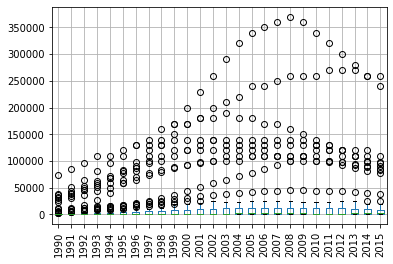

In [ ]:
children_HIV_df.boxplot(column=used_years,rot=90)

#### Data Percentage Distribution By Country
**Motivation:** In the dataset, there is geographic information. I am curious about the average precentage distribution of HIV counts for children (0-14) living with HIV around the world.

**Conclusion:** From the pie chart below, we see that the top three countries that have high percentage of children living with HIV is South Africa, Nigeria, and Kenya.

In [ ]:
px.pie(children_HIV_df, values='mean', names='Country Code',
       title='Average Children HIV Percentage for Different Countries',
       color_discrete_sequence=px.colors.sequential.RdBu)

#### Data Percentage Distribution By Continents
**Motivation:** In the dataset, there is geographic information. I am curious about the average precentage distribution of HIV counts for children (0-14) living with HIV around different continents.

**Conclusion:** From the pie chart below, we can see that the Africa continent has the highest precentage of HIV counts for children (0-14), which is 95%.

In [ ]:
px.pie(children_HIV_df, values='mean', names='Continent Name',
       title='Average Children HIV Percentage for Different Continents',
       color_discrete_sequence=px.colors.sequential.RdBu)

#### Data Distribution By Country
**Motivation:** I am curious about the average data distribution of HIV counts for children (0-14) living with HIV around the world.

In [ ]:
fig = px.scatter_geo(total_HIV_df, locations="Country Code",
                     color="Country Name", # which column to use to set the color of markers
                     hover_name="Country Name", # column added to hover information
                     size="mean", # size of markers
                     projection="orthographic",
                     title="Average Total HIV Counts for different Countries from 1990 to 2015")
fig

#### Data Distribution By Continents
**Motivation:** I am curious about the average precentage distribution of HIV counts for children (0-14) living with HIV around different continents.

In [ ]:
fig = px.scatter_geo(children_HIV_df, locations="Country Code",
                     color="Continent Name", # which column to use to set the color of markers
                     hover_name="Country Name", # column added to hover information
                     size="mean", # size of markers
                     projection="orthographic",
                     title="Average Children HIV Counts for different Continents from 1990 to 2015")
fig

## Severe Countries Visualization

Those are countries with high HIV counts over the past 30 years.

In [ ]:
severe_countries=total_HIV_df.sort_values(by=["mean"],ascending=False).head(5)
severe_countries

,Country Name,Country Code,Indicator Name,Indicator Code,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,Continent Code,Continent Name,mean
74868,South Africa,ZAF,Adults (ages 15+) and children (0-14 years) li...,SH.HIV.TOTL,210000.0,360000.0,590000.0,930000.0,1400000.0,2000000.0,2700000.0,3400000.0,4100000.0,4700000.0,5300000.0,5800000.0,6100000.0,6400000.0,6500000.0,6500000.0,6500000.0,6500000.0,6400000.0,6400000.0,6400000.0,6400000.0,6500000.0,6600000.0,6800000.0,7000000.0,AF,Africa,4.711154e+06
63828,Nigeria,NGA,Adults (ages 15+) and children (0-14 years) li...,SH.HIV.TOTL,700000.0,850000.0,1000000.0,1200000.0,1400000.0,1700000.0,1900000.0,2100000.0,2300000.0,2500000.0,2700000.0,2800000.0,2800000.0,2900000.0,3000000.0,3000000.0,3000000.0,3000000.0,3100000.0,3100000.0,3200000.0,3200000.0,3300000.0,3300000.0,3400000.0,3500000.0,AF,Africa,2.498077e+06
44508,India,IND,Adults (ages 15+) and children (0-14 years) li...,SH.HIV.TOTL,160000.0,250000.0,380000.0,540000.0,740000.0,960000.0,1200000.0,1400000.0,1700000.0,1900000.0,2000000.0,2100000.0,2200000.0,2300000.0,2300000.0,2300000.0,2300000.0,2200000.0,2200000.0,2200000.0,2200000.0,2100000.0,2100000.0,2100000.0,2100000.0,2100000.0,AS,Asia,1.693462e+06
48648,Kenya,KEN,Adults (ages 15+) and children (0-14 years) li...,SH.HIV.TOTL,700000.0,900000.0,1100000.0,1300000.0,1500000.0,1700000.0,1800000.0,1800000.0,1800000.0,1800000.0,1700000.0,1700000.0,1600000.0,1500000.0,1400000.0,1400000.0,1300000.0,1300000.0,1300000.0,1300000.0,1400000.0,1400000.0,1400000.0,1500000.0,1500000.0,1500000.0,AF,Africa,1.446154e+06
88668,Zimbabwe,ZWE,Adults (ages 15+) and children (0-14 years) li...,SH.HIV.TOTL,790000.0,960000.0,1100000.0,1300000.0,1400000.0,1500000.0,1600000.0,1700000.0,1700000.0,1700000.0,1700000.0,1600000.0,1500000.0,1500000.0,1400000.0,1300000.0,1300000.0,1200000.0,1200000.0,1200000.0,1200000.0,1300000.0,1300000.0,1300000.0,1400000.0,1400000.0,AF,Africa,1.367308e+06


In [ ]:
severe_countries_name=severe_countries["Country Name"].tolist()
print(severe_countries_name)

['South Africa', 'Nigeria', 'India', 'Kenya', 'Zimbabwe']


We can see most severe contries are in Africa.

# Part 3 : Indicator Analysis

##Explore Indicator Names

* Here I groupby the *Indicator Name* column to obtain the list of indicators that are available in the data. So that, I could filter through the list to identify or select which indicators are most likely related to the HIV counts among male, female, or children.

In [ ]:
indicators_df = cleaned_df.groupby("Indicator Name")["Country Name"].count().reset_index().rename({"Country Name":"Count"},axis="columns").sort_values('Count', ascending = False).reset_index().iloc[: , 1:]

In [ ]:
indicators_list = indicators_df["Indicator Name"].tolist()
indicators_list

['Population, total',
 'Urban population growth (annual %)',
 'Urban population (% of total)',
 'Urban population',
 'Population growth (annual %)',
 'Age at first marriage, female',
 'Age at first marriage, male',
 'Incidence of tuberculosis (per 100,000 people)',
 'Share of women employed in the nonagricultural sector (% of total nonagricultural employment)',
 'Prevalence of tuberculosis (per 100,000 population)',
 'Tuberculosis case detection rate (all forms)',
 'Tuberculosis death rate (per 100,000 people)',
 'Rural population growth (annual %)',
 'Death rate, crude (per 1,000 people)',
 'Birth rate, crude (per 1,000 people)',
 'Rural population (% of total population)',
 'Rural population',
 'Physicians (per 1,000 people)',
 'Diabetes prevalence (% of population ages 20 to 79)',
 'Improved water source, urban (% of urban population with access)',
 'Improved water source (% of population with access)',
 'Improved sanitation facilities (% of population with access)',
 'Improved sani

## Correlation between People's Health and HIV

Exploring the correlation between people's health condition and prevelence of HIV among people.

Here, I have done the follwing things:

1. Filter the data based on human's health condition such as tuberculosis deadth rate, life expectancy, risk of catastrophic expenditure for surgical case, etc.
2. Filter the data based on the prevalence of HIV among people.
3. Peform correlation matrix using the filtered data.
4. Plot heatmap to show the correlation results.

In [ ]:
indicators_risk = indicators_df[indicators_df["Indicator Name"].apply(lambda x : 'risk' in x.lower() or 'life expectancy' in x.lower() or 'death rate' in x.lower())]
indicators_risk_list = indicators_risk["Indicator Name"].tolist()
indicators_risk_list

['Tuberculosis death rate (per 100,000 people)',
 'Death rate, crude (per 1,000 people)',
 'Life expectancy at birth, female (years)',
 'Life expectancy at birth, total (years)',
 'Life expectancy at birth, male (years)',
 'Risk of catastrophic expenditure for surgical care (% of people at risk)',
 'Lifetime risk of maternal death (%)',
 'Lifetime risk of maternal death (1 in: rate varies by country)',
 'Risk of impoverishing expenditure for surgical care (% of people at risk)']

In [ ]:
hiv_influence_df = cleaned_df[cleaned_df["Indicator Name"].apply(lambda x : x in indicators_risk_list or 'Prevalence of HIV' in x)].groupby("Indicator Name").sum().reset_index()

**Conclusion:** Based on the heatmap below, the selected indicator risks do not show a high correlation with the prevalence of HIV in male or female. However, the heatmap indicates that the prevalence of HIV in male and the prevalence of HIV in female has a high correlation of 0.97.

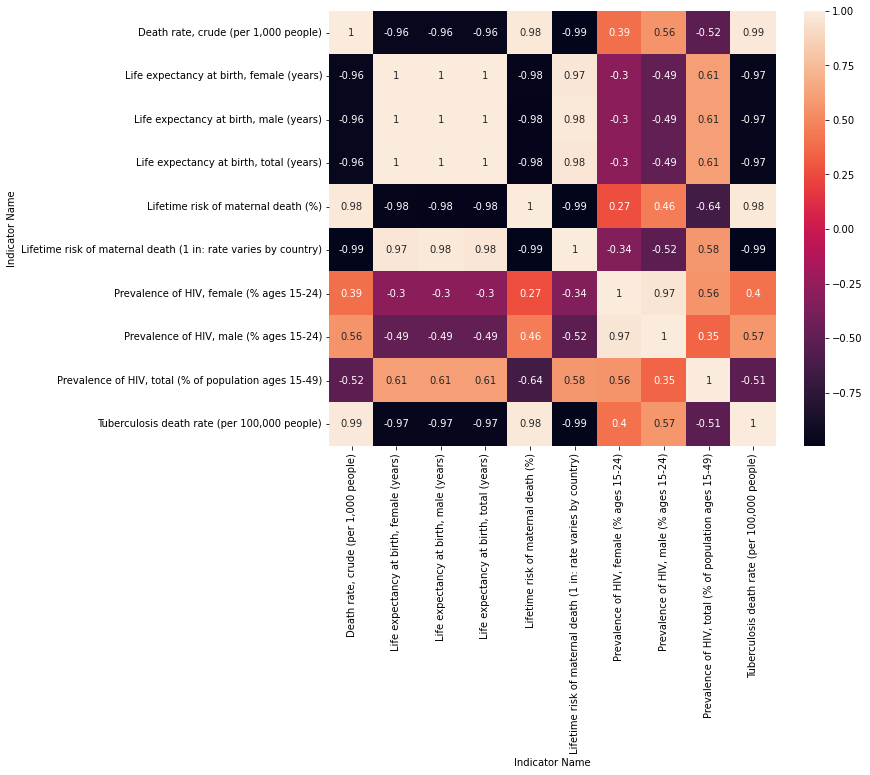

In [ ]:
hiv_influence = hiv_influence_df.set_index('Indicator Name').transpose()
cols = [9,10]
hiv_influence.drop(hiv_influence.columns[cols],axis=1,inplace=True)
# temp.rename_axis('year',axis=0).set_axis(["children living with HIV", "children newely infected with hiv","children orphaned by HIV","condom_female", "condom_male"], axis=1, inplace=False)
hiv_influence = hiv_influence.iloc[:-1]
hiv_influence_corr = hiv_influence.astype('float64').corr()
plt.figure(figsize=(10,8))
sns.heatmap(hiv_influence_corr, annot = True)
plt.show()

## Explore correlation between Condom use and prevalence of HIV

Here I have done the following things:

1. Filter the data based on the use of condom for male and female.
2. Filter the data based on the prevalence of HIV in male and female.
3. Compare between the filtered data.
4. Peformed correlation matrix based on the filtered data to explore how the use of condom for male and female affect the HIV count for children.

### Male

In [ ]:
condom_hiv_male = cleaned_df[cleaned_df['Indicator Name'].apply(lambda x : ('HIV' in x and'male' in x and '15-24' in x and 'female' not in x)
                                                        or('Condom use' in x and'male' in x and '15-24' in x and 'female' not in x))].groupby("Indicator Name").sum().reset_index()
condom_hiv_male
condom_hiv_male = condom_hiv_male.iloc[1: , :]
condom_hiv_male =condom_hiv_male.transpose().iloc[1: , :]
condom_hiv_male = condom_hiv_male.rename_axis('year',axis=0).set_axis(["condom", "prevalence"], axis=1, inplace=False)
condom_hiv_male = condom_hiv_male[(condom_hiv_male != 0).all(1)]

In [ ]:
condom_hiv_male

,condom,prevalence
year,,
1994,48.5,94.1
1995,59.1,100.2
1996,171.4,104.1
1997,11.4,105.5
1998,164.2,105.5
1999,238.5,102.4
2000,195.8,99.3
2001,118.7,95.5
2002,151,90.3


**Result:** From the visual below, it shows that the use of condom only slightly bring down the number of prevalence of HIV among male (ages 15-24).

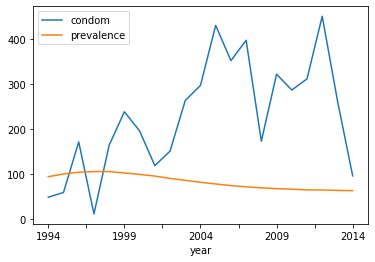

In [ ]:
condom_hiv_male.plot.line()

In [ ]:
condom_hiv_male.astype('float64').corr()

,condom,prevalence
condom,1.000000,-0.598215
prevalence,-0.598215,1.000000


### Female

In [ ]:
condom_hiv_female = cleaned_df[cleaned_df['Indicator Name'].apply(lambda x : ('HIV' in x and'female' in x and '15-24' in x)
                                                        or('Condom use' in x and'female' in x and '15-24' in x))].groupby("Indicator Name").sum().reset_index()
condom_hiv_female = condom_hiv_female.iloc[1: , :]
condom_hiv_female=condom_hiv_female.transpose().iloc[1: , :]
condom_hiv_female = condom_hiv_female.rename_axis('year',axis=0).set_axis(["condom", "prevalence"], axis=1, inplace=False)
condom_hiv_female = condom_hiv_female[(condom_hiv_female != 0).all(1)]

**Result:** From the visual below, it shows that the use of condom had bring down the number of prevalence of HIV among female (ages 15-24). Before year 2004, the number of prevalence of HIV among female (ages 15-24) are high, while the number for the use of condom around that time is low. However, after year 2004, the number of use of condom increased and the number of prevalence of HIV among female (ages 15-24) decreased.

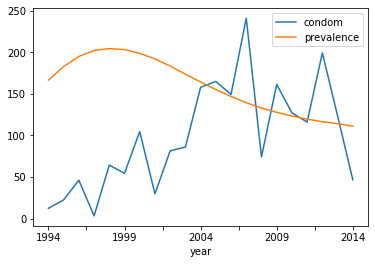

In [ ]:
# the trend of condom use and prevalence of HIV in female
condom_hiv_female.plot.line()

In [ ]:
# correlation metrix
condom_hiv_female.astype('float64').corr()

,condom,prevalence
condom,1.000000,-0.553529
prevalence,-0.553529,1.000000


### Children

In [ ]:
condom_hiv_children = cleaned_df[cleaned_df['Indicator Name'].apply(lambda x : ('Children' in x and 'HIV' in x)
                                                        or('Condom use' in x and'male' in x and '15-24' in x ))].groupby("Indicator Name").sum().reset_index()
condom_hiv_children = condom_hiv_children
condom_hiv_children=condom_hiv_children.transpose().iloc[1: , :]

condom_hiv_children = condom_hiv_children.rename_axis('year',axis=0).set_axis(["children living with HIV", "children newely infected with hiv","children orphaned by HIV","condom_female", "condom_male"], axis=1, inplace=False)
condom_hiv_children = condom_hiv_children[(condom_hiv_children != 0).all(1)]

**Result:** Based on the heatmap below, we can tell that the use of condom has correlation with the number of children living with HIV.

* the correlation value between children living with HIV and condom use in male is 0.74.

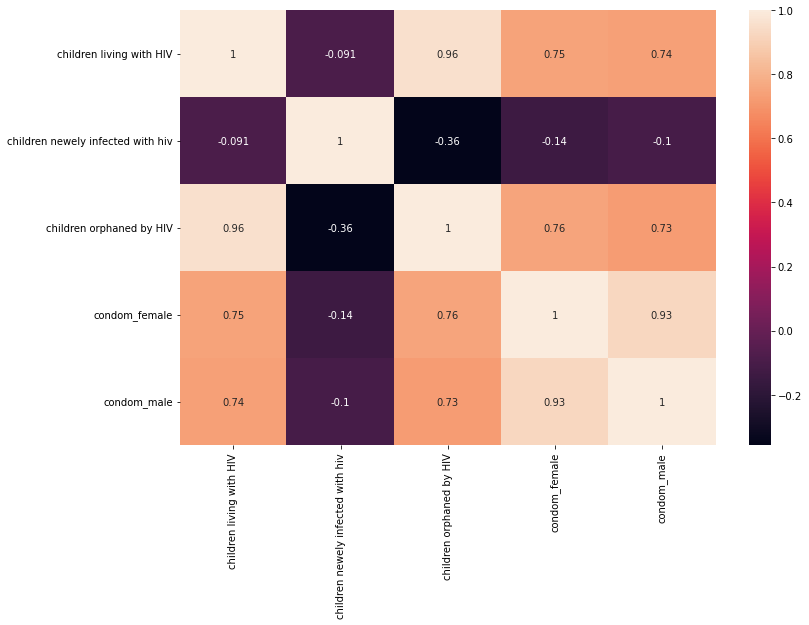

In [ ]:

condom_children_corr = condom_hiv_children.astype('float64').corr()
plt.figure(figsize=(12,8))
sns.heatmap(condom_children_corr, annot = True)
plt.show()

## Correlation between people's comprehensive correct knowledge about HIV and the prevelence of HIV

Exploring the correlation between people's comprehensive correct knowledge about HIV and prevelence of HIV among people.

Here, we do the follwing things:

1. Filter the data based on the keyword 'comprehensive correct knowledge' for male and female.
2. Filter the data based on the prevalence of HIV among people.
3. Plot line graph to show the relationship between the filtered data.

### Male

In [ ]:
knowledge_hiv_male = cleaned_df[cleaned_df['Indicator Name'].apply(lambda x : ('HIV' in x and'male' in x and '15-24' in x and 'female' not in x)
                                                        or('Comprehensive correct knowledge of HIV/AIDS' in x and 'male' in x and '15-24' in x and 'female' not in x))].groupby("Indicator Name").sum().reset_index()
knowledge_hiv_male
knowledge_hiv_male = knowledge_hiv_male.transpose().iloc[1: , :]
knowledge_hiv_male = knowledge_hiv_male.rename_axis('year',axis=0).set_axis(["Comprehensive correct knowledge", "prevalence"], axis=1, inplace=False)
knowledge_hiv_male = knowledge_hiv_male[(knowledge_hiv_male != 0).all(1)]

**Result:** Based on the line plot below, it indicates that having comprehensive correct knowledge of HIV/AIDS among male doesn't affect the prevalence of HIV among male ages 15-24.

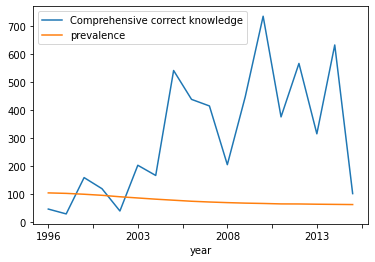

In [ ]:
# the trend of comprehensive correct knowledge of HIV in male
knowledge_hiv_male.plot.line()

### Female

In [ ]:
knowledge_hiv_female = cleaned_df[cleaned_df['Indicator Name'].apply(lambda x : ('HIV' in x and'female' in x and '15-24' in x)
                                                                     or ('Comprehensive correct knowledge' in x and'female' in x and '15-24' in x))].groupby("Indicator Name").sum().reset_index()
knowledge_hiv_female = knowledge_hiv_female.transpose().iloc[1: , :]
knowledge_hiv_female = knowledge_hiv_female.rename_axis('year',axis=0).set_axis(["Comprehensive correct knowledge", "prevalence"], axis=1, inplace=False)
knowledge_hiv_female = knowledge_hiv_female[(knowledge_hiv_female != 0).all(1)]

**Result:** While for female, based on the line plot below, it indicates that having comprehensive correct knowledge of HIV/AIDS slightly affect the prevalence of HIV among female ages 15-24. The line that represents prevalence of HIV among female slightly went down a little.

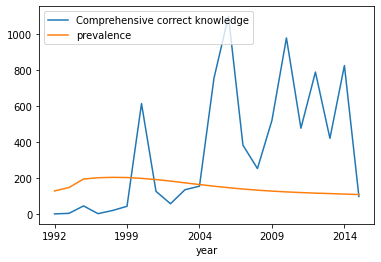

In [ ]:
# the trend of comprehensive correct knowledge of HIV in female
knowledge_hiv_female.plot.line()

# Part 4 : Models for Predicting HIV

In [ ]:
world_total_df=world_df[world_df["Indicator Code"]=="SH.HIV.TOTL"]
world_children_df=world_df[world_df["Indicator Code"]=="SH.HIV.0014"]

In [ ]:
world_total_df

,Country Name,Country Code,Indicator Name,Indicator Code,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
13803,World,WLD,Adults (ages 15+) and children (0-14 years) li...,SH.HIV.TOTL,9100000.0,10900000.0,12900000.0,15000000.0,17200000.0,19500000.0,21700000.0,23900000.0,25900000.0,27500000.0,28900000.0,30000000.0,30700000.0,31200000.0,31500000.0,31800000.0,31900000.0,32100000.0,32400000.0,32800000.0,33300000.0,33900000.0,34500000.0,35200000.0,35900000.0,36700000.0


### Convariance Matrix Analysis -- Correlation exploration

Exploring correlations of bewtween various Indicator Name(features).
Then, retrieve the Indicator Names(features) that have highest positive correlation value with the total count of people living with HIV.

* Group by the data by Indicator Name.
* Transpose the data from row to column.
* Fit the dataframe into the correlation matrix.
* Flatten the correlation data frame.
* Filter the relevant features by correlation values that are above 0.8 and below 1.
* Retrive the relevant feature names in a list.

In [ ]:
average_indicator_df = cleaned_df.groupby(["Indicator Name"]).mean().reset_index().transpose()
average_indicator_df.columns = average_indicator_df.iloc[0]
average_indicator_df = average_indicator_df[1:]

corr = average_indicator_df.astype('float64').corr()

# Unstack the correlation df into a list and sort by descending order
corr_list = corr.unstack().sort_values(ascending=False)

# Selecting highly correlated features
cor_target = abs(corr['Adults (ages 15+) and children (0-14 years) living with HIV'])

# Select features with corr relation value higher than 0.8 and not 1
relevant_features = cor_target[cor_target>0.8]
relevant_features = relevant_features[relevant_features!=1]
relevant_features = relevant_features.reset_index()
features = relevant_features['Indicator Name'].tolist()

# reference = https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b

In [ ]:
features

['AIDS estimated deaths (UNAIDS estimates)',
 'Adolescent fertility rate (births per 1,000 women ages 15-19)',
 'Adults (ages 15+) living with HIV',
 'Age dependency ratio (% of working-age population)',
 'Age dependency ratio, old',
 'Age dependency ratio, young',
 'Age population, age 11, male, interpolated',
 'Age population, age 12, male, interpolated',
 'Age population, age 13, female, interpolated',
 'Age population, age 13, male, interpolated',
 'Age population, age 14, female, interpolated',
 'Age population, age 14, male, interpolated',
 'Age population, age 15, female, interpolated',
 'Age population, age 15, male, interpolated',
 'Age population, age 16, female, interpolated',
 'Age population, age 16, male, interpolated',
 'Age population, age 17, female, interpolated',
 'Age population, age 17, male, interpolated',
 'Age population, age 18, female, interpolated',
 'Age population, age 18, male, interpolated',
 'Age population, age 19, female, interpolated',
 'Age populatio

Generate X features and Y label by "Groupby" function" so that each rows is all indicator results for a country in specific year. We extract the following 8 features because they are more approaching to our guess.

In [ ]:
# Create a copy of df with selected corr features/indicators
selected_features=["Fertility rate, total (births per woman)","Labor force, total","Life expectancy at birth, total (years)","Lifetime risk of maternal death (%)",'Improved sanitation facilities (% of population with access)','Improved water source (% of population with access)','Population, total','Sex ratio at birth (male births per female births)',"Adults (ages 15+) and children (0-14 years) living with HIV"]
boolean_series = cleaned_df['Indicator Name'].isin(selected_features)

total_HIV_corr_df = cleaned_df[boolean_series]

total_HIV_corr_df=total_HIV_corr_df.groupby(["Indicator Name", "Country Code"]).sum().unstack().transpose().reset_index()
total_HIV_corr_df=total_HIV_corr_df.dropna()
total_HIV_corr_df=total_HIV_corr_df[~(total_HIV_corr_df == 0).any(axis=1)][selected_features]
total_HIV_corr_df

Indicator Name,"Fertility rate, total (births per woman)","Labor force, total","Life expectancy at birth, total (years)",Lifetime risk of maternal death (%),Improved sanitation facilities (% of population with access),Improved water source (% of population with access),"Population, total",Sex ratio at birth (male births per female births),Adults (ages 15+) and children (0-14 years) living with HIV
3,7.208,4118283.0,41.138341,8.482329,22.4,45.7,11127870.0,1.0300,28000.0
6,2.989,13330838.0,71.543659,0.225988,87.4,93.8,32729740.0,1.0400,26000.0
10,1.902,8502257.0,76.994634,0.015994,100.0,100.0,17065100.0,1.0552,14000.0
13,7.542,2653640.0,48.000122,8.590470,41.7,68.8,5613141.0,1.0300,24000.0
15,6.744,1955656.0,53.420000,3.864932,6.8,57.1,5001271.0,1.0410,5100.0
...,...,...,...,...,...,...,...,...,...
4790,2.020,1763727.0,76.986146,0.031188,96.3,99.6,3419516.0,1.0500,10000.0
4794,1.961,54206654.0,75.629122,0.115190,76.3,96.4,90728900.0,1.1100,250000.0
4797,2.363,20001038.0,57.182122,0.341526,65.8,92.8,54058647.0,1.0300,6800000.0
4798,5.353,6720673.0,60.047049,1.317162,43.7,64.6,15721343.0,1.0300,1200000.0


### Select X features and Y for training data and testing data

*   Columns except for the *Adults (ages 15+) and children (0-14 years) living with HIV* are feature columns, will be treated as X.
*   *Adults (ages 15+) and children (0-14 years) living with HIV* column is the label that we want to predict, will be treated as y.

In [ ]:
y = total_HIV_corr_df["Adults (ages 15+) and children (0-14 years) living with HIV"]
X = total_HIV_corr_df.drop(columns=["Adults (ages 15+) and children (0-14 years) living with HIV"])

print("Features shape {}".format(X.shape))
print("Label shape {}".format(y.shape))

Features shape (1137, 8)
Label shape (1137,)


### Split the training data and testing data
*   80% of the data will be used for training, 20% of the data will be used for testing.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# check the training tensor and testing tensor size
print("Training Data Size: features x:{},  label y:{}".format(X_train.shape, y_train.shape))
print("Testing Data Size: features x:{},  label y:{}".format(X_test.shape, y_test.shape))

Training Data Size: features x:(909, 8),  label y:(909,)
Testing Data Size: features x:(228, 8),  label y:(228,)


### Linear Regression

In [ ]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

Implementing PCA to reduce dimensions and apply linear regression to the training data and testing data after PCA.

In [ ]:
X = StandardScaler().fit_transform(X_train)
pca = PCA(n_components=8)
X2 = pca.fit_transform(X)

Visualize the first two dimensions.

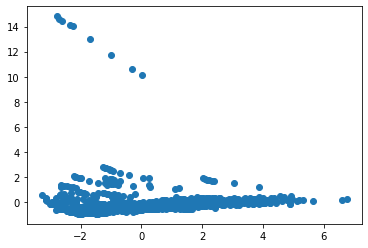

In [ ]:
plt.scatter(X2[:,0], X2[:,1])

Principal Components vs Explained Variance

In [ ]:
np.set_printoptions(suppress=True)
pca.explained_variance_ratio_

array([0.55336757, 0.26042258, 0.08827332, 0.03555235, 0.02684089,
       0.02001993, 0.01499533, 0.00052802])

[0.55336757 0.81379015 0.90206347 0.93761582 0.96445671 0.98447665
 0.99947198 1.        ]


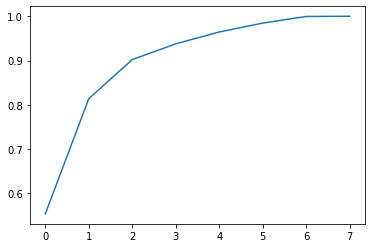

In [ ]:
# See how much is contributed by the first few terms
pc_vs_variance = np.cumsum(pca.explained_variance_ratio_)

print(pc_vs_variance)
plt.plot(pc_vs_variance)

Learning over PCA-Reduced Data

From the above, we saw how to do PCA on the overall dataset.
Here, we scaled down the dataset to 6.

In [ ]:
# Fit the PCA on the training data
pca = PCA(n_components=6)
pca.fit(X_train)
# and transform it
X_train_2 = pca.transform(X_train)

# Then train a simple linear regression classifier
# (tries to find the best weighted linear combination to
# match the output)
regr = linear_model.LinearRegression()
regr.fit(X_train_2, y_train)

X_train_2

array([[-3.73100982e+07, -9.52717740e+05,  8.57036160e+00,
        -2.17653376e+01,  8.96131329e-01, -1.11116567e-01],
       [-1.66563864e+07, -9.18445751e+05,  1.54075892e+01,
        -7.58942221e-01,  7.44890618e+00,  2.79807938e-01],
       [-3.65581247e+07, -7.54450281e+05, -1.03108779e+01,
        -1.48242701e+01,  5.20754722e+00, -9.31014699e-01],
       ...,
       [ 1.89287776e+06, -7.20530640e+05,  3.31585952e+01,
        -1.92332669e+01, -6.63018423e-01, -4.94922216e-02],
       [ 1.33432983e+08,  1.28333748e+07,  1.58306401e+01,
        -2.63652680e+00, -2.10458802e+00, -9.50067095e-03],
       [-2.97336421e+07, -5.81504468e+05, -3.14147347e+01,
         2.14460849e+01,  1.08465799e+00, -5.75897397e-01]])

In [ ]:
X_test_2 = pca.transform(X_test)

predictions = regr.predict(X_test_2)

print(regr.score(X_train_2, y_train))

print(regr.score(X_test_2, y_test))

0.22067508859352158
0.2488623962749984


In [ ]:
MSE = mean_squared_error(y_test, predictions) ** 0.5
print("Rooted mean square error: {}".format(MSE))
errors = y_test - predictions
#mean absolute error
MAE = np.average(np.abs(errors))
print("MAE: {}".format(MAE))

Rooted mean square error: 773386.8421336061
MAE: 328560.1956222646


 **Conclusion:**
* By using this model, accuracy on the training dataset is at 0.2206.  
* By using this model, accuracy on the testing dataset will be around 0.2486.
 <br> rooted mean square error: $RMSE=773386.8421$.  
 mean absolute error: $MAE=328560.1956180393$.

###Conducting Linear Regression with Penalty, such as Lasso, Ridge, and ElasticNet

####Lasso Model

In [ ]:
from sklearn.linear_model import ElasticNet
#LASSO L1
regr2 = ElasticNet(alpha=1.0, l1_ratio=1)
regr2.fit(X_train_2, y_train)
lasso_predict = regr2.predict(X_test_2)
print(regr2.score(X_train_2, y_train))
print(regr2.score(X_test_2, y_test))

0.22067508859198903
0.24886214600866408


In [ ]:
MSE = mean_squared_error(y_test, lasso_predict) ** 0.5
print("Rooted mean square error: {}".format(MSE))
lasso_errors = y_test - lasso_predict
#mean absolute error
MAE = np.average(np.abs(lasso_errors))
print("MAE: {}".format(MAE))

Rooted mean square error: 773386.9709732974
MAE: 328560.00514198584


 **Conclusion:**  
* By using the Lasso model, accuracy on the training dataset is 0.2206.
* By using the Lasso model, accuracy on the testing dataset is 0.2488.
 <br> rooted mean square error: $RMSE=773386.9709733082$.  
 mean absolute error: $MAE=328560.0051$.
* The result for the lasso model is very close to the result for the model without any penalty.

####RIDGE Model

In [ ]:
#RIDGE L2
regr3 = ElasticNet(alpha=1.0, l1_ratio=0)
regr3.fit(X_train_2, y_train)
ridge_predict = regr3.predict(X_test_2)
print(regr3.score(X_train_2, y_train))
print(regr3.score(X_test_2, y_test))

0.21679842450688247
0.23543471752958445


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.616e+14, tolerance: 4.082e+10 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



In [ ]:
MSE = mean_squared_error(y_test, ridge_predict) ** 0.5
print("Rooted mean square error: {}".format(MSE))
ridge_errors = y_test - ridge_predict
#mean absolute error
MAE = np.average(np.abs(ridge_errors))
print("MAE: {}".format(MAE))

Rooted mean square error: 780268.9296842545
MAE: 321050.69029231695


 **Conclusion:**   
* By using the Ridge model, accuracy on the training dataset is 0.2167.
* By using the Ridge model, accuracy on the testing dataset is 0.2354.
 <br> rooted mean square error: $RMSE=780268.9296$.  
 mean absolute error: $MAE=321050.6902$.

####L1 combined with L2

In [ ]:
#L1 combined with L2
regr4 = ElasticNet(alpha=0.1, l1_ratio=0.6)
regr4.fit(X_train_2, y_train)
elastic_predict = regr4.predict(X_test_2)
print(regr4.score(X_train_2, y_train))
print(regr4.score(X_test_2, y_test))

0.22065941722924987
0.24818166613711679


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.239e+12, tolerance: 4.082e+10



In [ ]:
MSE = mean_squared_error(y_test, elastic_predict) ** 0.5
print("Rooted mean square error: {}".format(MSE))
elastic_errors = y_test - elastic_predict
#mean absolute error
MAE = np.average(np.abs(elastic_errors))
print("MAE: {}".format(MAE))

Rooted mean square error: 773737.2096982157
MAE: 327999.30955752113


 **Conclusion:**   
* By using the Elastic model, accuracy on the training dataset is 0.2206.
* By using the Elastic model, accuracy on the testing dataset is 0.2481.
 <br> rooted mean square error: $RMSE=773737.2096$.  
 mean absolute error: $MAE=327999.3095$.

Ridge L2 does not converge. For others, their testing accuracy is still lower than pure Linear regression.

###Regression Tree (a decision tree that can work on continous variable)
We tried regression tree with different splitters ("best" and "random").

"best": choose the best split.

"random": choose the best random split.

The result is shown below. The max testing accuracy is over 80%.

In [ ]:
from sklearn import tree
trainVal=0
maxTestVal=0
maxS=0
maxP=0
for method in ["best", "random"]:
  regr5 = tree.DecisionTreeRegressor(splitter=method)
  regr5.fit(X_train_2, y_train)
  p=regr5.predict(X_test_2)
  val=regr5.score(X_test_2, y_test)
  trainVal=regr5.score(X_train_2, y_train)
  print(trainVal,val,method, "splitter")
  MSE = mean_squared_error(y_test, p) ** 0.5
  print("Rooted mean square error: {}".format(MSE))
  error = y_test - p
  #mean absolute error
  MAE = np.average(np.abs(error))
  print("MAE: {}".format(MAE))
  print("")

1.0 0.6218616433060082 best splitter
Rooted mean square error: 548734.6606176412
MAE: 109028.50877192983

1.0 0.8327080479578981 random splitter
Rooted mean square error: 364984.60908430244
MAE: 99092.54385964913



 **Conclusion:**
* By using this model, accuracy on the training dataset is at 1.0 since we do the split until all leaves are pure.  
* By using this model, accuracy on the testing dataset (one running) is around 0.6218 (best splitter) and 0.8327 (random splitter).
 <br> rooted mean square error: $RMSE=548734.6606176412$ (best splitter), $RMSE=364984.60908430244$ (random splitter).  
 mean absolute error: $MAE=109028.50877192983$ (best splitter), $MAE=109028.50877192983$ (random splitter).

Totally, the regression tree works super better, with best testing accuracy over 80%. The RMSE and MAE here are still high, but improved a lot.

# Part 5 : Model Motivation, Comparison and Conclusion
* （Why did we choose those models?）Since we are willing to use supervised learning, we firstly extract some features more related to HIV count to help predict by correlation analsyis. We used PCA (unsupervised learning) to reduce dimensional and apply supervised learning models after that. Linear Regression models (Orinary, with Penalty) are used here because we want to find the linear relationship between features and labels. We also want to build a decision tree model working on continous variable. Based on our research, we took adavantage of the property of regression tree and chose different splitters running on it.
* The best model here is Regression Tree Model with "random" splitter. Linear models totally had weak performance. One reason is that the data samples here are not very large after we group by the countries in different years. NA deletion here also has bad negative impact of the size of our training and testing data. We hope to get better performance on linear models if more related data provided here. But we have to say there is a high probability existing some kind of nonlinear relationship. Regression Tree works much better here because it can capture some relationship beyond linearity.
*   After tuning the paramaters, performance of Lasso/Ridge regression model is not improved. The performance of Lasso/Ridge model has the similar accuracy as the default model, which is around 24% - 25%. For the decision tree, we consider the hyperparamer "splitter" (can be "best" or "random" split) to choose the best regression tree model. And we always find "random" split gives us a better result, which is over 80%.

# Part 6 : Challenges and Obstacles Faced

* **Duplicate Data:** There are duplication in data, due to countries are included in continents or regions. Also, some indicators has overlapping data. For example, the data for *Life expectancy at birth, female (years)* and *Life expectancy at birth, male (years)* are included in *Life expectancy at birth, total (years)*.

* **Data size:** The data is stored based on the various countries and indicatiors in row format, while years are in columns. Therefore, in order for us to select the proper features, we would have to transpose the data frame. This limited the row size because there are only 26 years of data we could use. The years prior to 1990 are lacking most of the data value, which we had dropped.

* **Select features:** Additionally, not every feature has the complete data for all 26 years, which forced us to further drop additional rows that contain null value so we could train the data set properly. This issue further reduced our data size.

* **Time Series:** We are trying to use time series method covered in the lecture. However, there are only 26 valid years without detailed montly stat. Our seasonality analysis cannot work well on this.

# Part 7 : Further Exploration

* We can try methods covered in the lecture to replace NA with aggregation or KNN value to keep more training data here.
* We can also explore more HIV data specific to months (since the Kaggle Data only covers yearly statistics) so that our generated data with features and labels would be large.